In [0]:
from glob import glob
from sklearn.model_selection import train_test_split

In [0]:
cats = glob('train/Cat/*.jpg')
dogs = glob('train/Dog/*.jpg')

cats_train, cats_test = train_test_split(cats, test_size=0.30)
dogs_train, dogs_test = train_test_split(dogs, test_size=0.30)

TRAIN_DIR = 'train'
TEST_DIR = 'test'

!mkdir test

!mkdir test/Cat
files = ' '.join(cats_test)
!mv -t test/Cat $files

!mkdir test/Dog
files = ' '.join(dogs_test)
!mv -t test/Dog $files

In [0]:
import os, shutil

TRAIN_DIR = '/content/train'
VAL_DIR = '/content/test'
CATS_TRAIN_DIR = '/content/train/Cat'
DOGS_TRAIN_DIR = '/content/train/Dog'

In [0]:
def img_deproc(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  
  x += 0.5
  x = np.clip(x,0,1)
  
  x *= 255
  x = np.clip(x,0,255).astype('uint8')
  return x

In [0]:
def create_pattern(model, layer_name, filter_idx, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:,:,:,filter_idx])
  
  grad = K.gradients(loss, model.input)[0]
  grad /= (K.sqrt(K.mean(K.square(grad))) + 1e-5) 
  
  iterate = K.function([model.input], [loss,grad])
  input_img_data = np.random.random((1,size,size,3))*20 + 128.
  
  step = 1.
  for i in range(40):
    loss_value, grad_value = iterate([input_img_data])
    input_img_data += grad_value*step
    
  img = input_img_data[0]
  return img_deproc(img)

In [0]:
def visualize(model, layer_name):
  count = 0
  n_rows = 8
  n_columns = 8

  f, axarr = plt.subplots(nrows=n_rows, ncols=n_columns, 
                          sharex=True, sharey=True,
                          figsize=(20,20))

  #if layer_name == 'all':
    
  #else:
  #plt.suptitle(layer_name)
  for column in range(n_columns):
    for row in range(n_rows):
      axarr[row, column].imshow(create_pattern(model, layer_name, count, size=64))
      f.subplots_adjust(hspace=0.01, wspace=0.01)
      count += 1

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=30,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

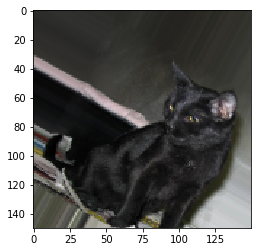

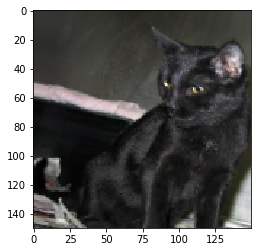

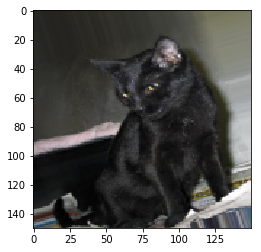

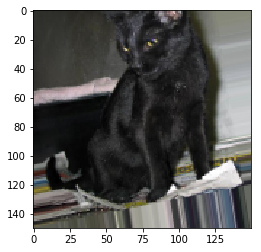

In [0]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

fnames = [os.path.join(CATS_TRAIN_DIR, fname) for fname in os.listdir(CATS_TRAIN_DIR)]

image_path = fnames[4]
#print(image_path)
img = image.load_img(image_path, target_size=(150,150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size = 1):
  plt.figure(i)
  image_plot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  #print(i)
  if i%4 == 0:
    break
    
plt.show()

In [0]:
from keras import layers
from keras import models

input_shape = (150,150,3)
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

W0616 16:08:08.543987 140034602452864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0616 16:08:08.551128 140034602452864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0616 16:08:08.557101 140034602452864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_gen_rescale = ImageDataGenerator(rescale=1./255)
val_gen_rescale = ImageDataGenerator(rescale=1./255)

train_gen = train_gen_rescale.flow_from_directory(TRAIN_DIR,
                                              target_size=(150,150),
                                              batch_size=5,
                                              class_mode='binary')

val_gen = val_gen_rescale.flow_from_directory(VAL_DIR,
                                             target_size=(150,150),
                                             batch_size=5,
                                             class_mode='binary')
                                             

Found 17498 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [0]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=100,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=3)

model.save('cats_dogs_model.h5')

Epoch 1/20
100/100 [==============================] - 8s 82ms/step - loss: 0.6943 - acc: 0.4980 - val_loss: 0.7016 - val_acc: 0.2667
Epoch 2/20
100/100 [==============================] - 2s 18ms/step - loss: 0.6914 - acc: 0.5360 - val_loss: 0.6841 - val_acc: 0.6000
Epoch 3/20
100/100 [==============================] - 2s 19ms/step - loss: 0.6911 - acc: 0.5280 - val_loss: 0.6876 - val_acc: 0.6000
Epoch 4/20
100/100 [==============================] - 2s 18ms/step - loss: 0.6921 - acc: 0.5340 - val_loss: 0.6874 - val_acc: 0.5333
Epoch 5/20
 13/100 [==>...........................] - ETA: 1s - loss: 0.6918 - acc: 0.5692

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting t

100/100 [==============================] - 2s 19ms/step - loss: 0.6878 - acc: 0.5380 - val_loss: 0.7432 - val_acc: 0.2667
Epoch 6/20
100/100 [==============================] - 2s 21ms/step - loss: 0.6915 - acc: 0.5240 - val_loss: 0.6615 - val_acc: 0.7333
Epoch 7/20
100/100 [==============================] - 2s 20ms/step - loss: 0.6896 - acc: 0.5200 - val_loss: 0.6893 - val_acc: 0.5333
Epoch 8/20
100/100 [==============================] - 2s 19ms/step - loss: 0.6854 - acc: 0.5640 - val_loss: 0.6840 - val_acc: 0.4667
Epoch 9/20
100/100 [==============================] - 2s 19ms/step - loss: 0.6867 - acc: 0.5440 - val_loss: 0.6942 - val_acc: 0.4667
Epoch 10/20
100/100 [==============================] - 2s 19ms/step - loss: 0.6870 - acc: 0.5220 - val_loss: 0.6978 - val_acc: 0.4000
Epoch 11/20
100/100 [==============================] - 2s 20ms/step - loss: 0.6793 - acc: 0.5460 - val_loss: 0.6800 - val_acc: 0.6000
Epoch 12/20
100/100 [==============================] - 2s 19ms/step - loss: 0.

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

100/100 [==============================] - 2s 19ms/step - loss: 0.6781 - acc: 0.5600 - val_loss: 0.6979 - val_acc: 0.3333
Epoch 15/20
 28/100 [=======>......................] - ETA: 1s - loss: 0.6797 - acc: 0.5643

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

100/100 [==============================] - 2s 19ms/step - loss: 0.6735 - acc: 0.5740 - val_loss: 0.7385 - val_acc: 0.2000
Epoch 16/20
100/100 [==============================] - 2s 19ms/step - loss: 0.6745 - acc: 0.5940 - val_loss: 0.6922 - val_acc: 0.5333
Epoch 17/20
100/100 [==============================] - 2s 19ms/step - loss: 0.6739 - acc: 0.5800 - val_loss: 0.6929 - val_acc: 0.4667
Epoch 18/20
100/100 [==============================] - 2s 19ms/step - loss: 0.6741 - acc: 0.5820 - val_loss: 0.7416 - val_acc: 0.4667
Epoch 19/20
100/100 [==============================] - 2s 19ms/step - loss: 0.6658 - acc: 0.6060 - val_loss: 0.6746 - val_acc: 0.6667
Epoch 20/20
100/100 [==============================] - 2s 19ms/step - loss: 0.6577 - acc: 0.6100 - val_loss: 0.6464 - val_acc: 0.6000


In [25]:
from keras.models import load_model
model = load_model('cats_dogs_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [26]:
image_path = 'Cats.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(image_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


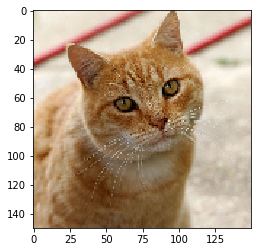

In [27]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [0]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]

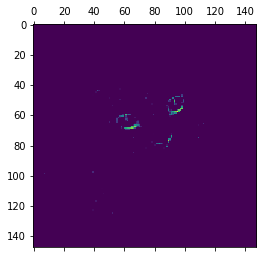

In [35]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0,:,:,9], cmap='viridis')